In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
folder = '/home/olga/data_sm/kmer-hashing/classify_coding_vs_noncoding/'

In [4]:
cd $folder

/mnt/data_sm/olga/kmer-hashing/classify_coding_vs_noncoding


In [5]:
ls

Homo_sapiens.GRCh38.cds.all.fa.gz
Homo_sapiens.GRCh38.ncrna.fa.gz
Homo_sapiens.GRCh38.pep.all.fa.gz
human_cds_k15.nodegraph
human_cds_k15.nodegraph.info
human_cds_k17.nodegraph
human_cds_k17.nodegraph.info
human_cds_k19.nodegraph
human_cds_k19.nodegraph.info
human_cds_k21.nodegraph
human_cds_k21.nodegraph.info
human_cds_k23.nodegraph
human_cds_k23.nodegraph.info
human_cds_k25.nodegraph
human_cds_k25.nodegraph.info
human_cds_k27.nodegraph
human_cds_k27.nodegraph.info
human_cds_k31.nodegraph
human_cds_k31.nodegraph.info
human_ncrna_k15.nodegraph
human_ncrna_k15.nodegraph.info
human_ncrna_k15.nodegraph.tagset
human_ncrna_k17.nodegraph
human_ncrna_k17.nodegraph.info
human_ncrna_k19.nodegraph
human_ncrna_k19.nodegraph.info
human_ncrna_k21.nodegraph
human_ncrna_k21.nodegraph.info
human_ncrna_k23.nodegraph
human_ncrna_k23.nodegraph.info
human_ncrna_k25.nodegraph
human_ncrna_k25.nodegraph.info
human_ncrna_k27.nodegraph
human_ncrna_k27.nodegraph.info
human_ncrna_k31.nodegraph
human_ncrna_k31.no

In [6]:
import gzip
from io import StringIO
from pprint import pprint

from khmer import Nodegraph
import matplotlib.pyplot as plt
import screed
from sourmash._minhash import hash_murmur
from khmer.khmer_args import calculate_graphsize
import pandas as pd
from sourmash.logging import notify
import seaborn as sns
from sklearn import metrics
from tqdm import tqdm
from Bio.Seq import Seq
from Bio import SeqIO

# make all warnings error to get a stack trace
import warnings
warnings.filterwarnings("default")

pd.options.display.max_colwidth = 100

from khtools.compare_kmer_content import kmerize, hpize, dayhoffize


In [7]:
from khtools.partition_reads import score_reads, make_peptide_bloom_filter, six_frame_translation_no_stops, is_low_complexity

In [8]:
%%time
peptide_ksize = 7

peptide_graph = make_peptide_bloom_filter("Homo_sapiens.GRCh38.pep.all.fa.gz", peptide_ksize)

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/screed/openscreed.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='Homo_sapiens.GRCh38.pep.all.fa.gz'>
  self.iter_fn = self.open_reader(filename, *args, **kwargs)


CPU times: user 37.2 s, sys: 1.44 s, total: 38.6 s
Wall time: 38.6 s


In [130]:
%%time

reads = 'SRR306838_GSM752691_hsa_br_F_1_trimmed.fq.gz'
subsampled_reads = 'SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.fq.gz'

coding_scores = score_reads(subsampled_reads, peptide_graph, peptide_ksize, #verbose=True, 
                            prefix='SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled')

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/screed/openscreed.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.fq.gz'>
  self.iter_fn = self.open_reader(filename, *args, **kwargs)
201it [00:00, 2003.74it/s]

Writing Noncoding nucleotides to SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.noncoding_nucleotides.fasta
Writing all valid protein-coding translation frames to SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.coding_peptides.fasta
Writing low complexity (low entropy) nucleotides to SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.low_complexity_nucleotides.fasta
Writing low complexity (low entropy) peptides to SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.low_complexity_peptides.fasta


1000it [00:00, 1997.85it/s]


CPU times: user 516 ms, sys: 8 ms, total: 524 ms
Wall time: 524 ms


In [131]:
print(coding_scores.shape)
coding_scores.head()

(1000, 4)


,read_id,jaccard_in_peptide_db,n_kmers,classification
0,SRR306838.10559374 Ibis_Run100924_C3PO:6:51:17601:17119/1,1.000000,16,coding
1,SRR306838.6196593 Ibis_Run100924_C3PO:6:29:16733:12435/1,0.000000,17,non-coding
2,SRR306838.20767303 Ibis_Run100924_C3PO:6:104:6864:5062/1,0.000000,16,non-coding
3,SRR306838.12582274 Ibis_Run100924_C3PO:6:62:11779:17975/1,0.066667,15,non-coding
4,SRR306838.13334230 Ibis_Run100924_C3PO:6:66:16579:20350/1,0.000000,12,non-coding


In [132]:
! ls -lha SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled*

-rw-rw-r-- 1 olga olga 26K Oct 11 23:03 SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.coding_peptides.fasta
-rw-r--r-- 1 olga olga 72K Sep 18 05:33 SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.fq.gz
-rw-rw-r-- 1 olga olga 132 Oct 11 23:03 SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.low_complexity_nucleotides.fasta
-rw-rw-r-- 1 olga olga   0 Oct 11 22:41 SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.low_complexity_peptides.fasta
-rw-rw-r-- 1 olga olga 91K Oct 11 23:03 SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.noncoding_nucleotides.fasta


In [133]:
! wc -l SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.*fasta

   514 SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.coding_peptides.fasta
     2 SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.low_complexity_nucleotides.fasta
     0 SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.low_complexity_peptides.fasta
  1488 SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.noncoding_nucleotides.fasta
  2004 total


In [134]:
coding_peptide_read_ids = [r['name'] for r in screed.open('SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.coding_peptides.fasta')]
print(len(coding_peptide_read_ids))
coding_peptide_read_ids[:5]

257


/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.coding_peptides.fasta'>
  """Entry point for launching an IPython kernel.


['SRR306838.10559374 Ibis_Run100924_C3PO:6:51:17601:17119/1 translation_frame: -1',
 'SRR306838.2740879 Ibis_Run100924_C3PO:6:13:11155:5248/1 translation_frame: 0',
 'SRR306838.4880582 Ibis_Run100924_C3PO:6:23:17413:5436/1 translation_frame: 1',
 'SRR306838.7944356 Ibis_Run100924_C3PO:6:38:5591:5659/1 translation_frame: 1',
 'SRR306838.12543451 Ibis_Run100924_C3PO:6:62:9024:13538/1 translation_frame: 2']

In [135]:
coding_peptide_read_ids_no_translation = [x.split("translation")[0].strip() for x in coding_peptide_read_ids]
print(len(coding_peptide_read_ids_no_translation))
coding_peptide_read_ids_no_translation[:5]

257


['SRR306838.10559374 Ibis_Run100924_C3PO:6:51:17601:17119/1',
 'SRR306838.2740879 Ibis_Run100924_C3PO:6:13:11155:5248/1',
 'SRR306838.4880582 Ibis_Run100924_C3PO:6:23:17413:5436/1',
 'SRR306838.7944356 Ibis_Run100924_C3PO:6:38:5591:5659/1',
 'SRR306838.12543451 Ibis_Run100924_C3PO:6:62:9024:13538/1']

In [136]:
noncoding_read_ids = [r['name'] for r in screed.open('SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.noncoding_nucleotides.fasta')]
print(len(noncoding_read_ids))
noncoding_read_ids[:5]

744


/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.noncoding_nucleotides.fasta'>
  """Entry point for launching an IPython kernel.


['SRR306838.6196593 Ibis_Run100924_C3PO:6:29:16733:12435/1',
 'SRR306838.20767303 Ibis_Run100924_C3PO:6:104:6864:5062/1',
 'SRR306838.12582274 Ibis_Run100924_C3PO:6:62:11779:17975/1',
 'SRR306838.13334230 Ibis_Run100924_C3PO:6:66:16579:20350/1',
 'SRR306838.6813354 Ibis_Run100924_C3PO:6:32:10591:13073/1']

In [137]:
len(set(coding_peptide_read_ids_no_translation) & set(noncoding_read_ids))

0

In [138]:
! head SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.*fasta

==> SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.coding_peptides.fasta <==
>SRR306838.10559374 Ibis_Run100924_C3PO:6:51:17601:17119/1 translation_frame: -1
TEQDLQLYCDFPNIIDVSIKQA
>SRR306838.2740879 Ibis_Run100924_C3PO:6:13:11155:5248/1 translation_frame: 0
QSSSPEFRVQSFSERTNARKKNNH
>SRR306838.4880582 Ibis_Run100924_C3PO:6:23:17413:5436/1 translation_frame: 1
LDPPYSRVITQRETENNQMTSE
>SRR306838.7944356 Ibis_Run100924_C3PO:6:38:5591:5659/1 translation_frame: 1
SDEHGIDPTGTYH
>SRR306838.12543451 Ibis_Run100924_C3PO:6:62:9024:13538/1 translation_frame: 2
QIDVNVQDHFWDGKGCEMIC

==> SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.low_complexity_nucleotides.fasta <==
>SRR306838.12400067 Ibis_Run100924_C3PO:6:61:13790:17730/1
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

==> SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.low_complexity_peptides.fasta <==

==> SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.noncoding_nucleotides.fasta <==
>SRR306838.6196593 Ib

In [116]:
! tail SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.*fasta

==> SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.coding_peptides.fasta <==
>SRR306838.19000486 Ibis_Run100924_C3PO:6:95:13556:19024/1 translation_frame: 1
ELEDKDLDFKNKDTDISIKP
>SRR306838.2523598 Ibis_Run100924_C3PO:6:12:11847:5371/1 translation_frame: 0
LMQNGKRLKKKKTTIKKNTLNPY
>SRR306838.17113907 Ibis_Run100924_C3PO:6:86:13459:13165/1 translation_frame: -1
QRFTNSAGPP
>SRR306838.10565223 Ibis_Run100924_C3PO:6:51:4756:17775/1 translation_frame: -2
CNVSSTMQSSINGNPPLPNP
>SRR306838.3389047 Ibis_Run100924_C3PO:6:16:6019:4984/1 translation_frame: -2
LIKKLPPVLAIQLKRFDYDWE
==> SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.low_complexity_nucleotides.fasta <==

>SRR306838.12400067 Ibis_Run100924_C3PO:6:61:13790:17730/1
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
==> SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.low_complexity_peptides.fasta <==

==> SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.noncoding_nucleotides.fasta <==
>SRR306838.19000486 Ibis_

In [ ]:
! samtools view 

In [ ]:
! wc -l SRR306838_GSM752691_hsa_br_F_1_trimmed_subsampled.*fasta

In [102]:
star_outdir = '/mnt/ibm_lg/olga/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/STAR'
bam = f'{star_outdir}/SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam'
print(bam)

/mnt/ibm_lg/olga/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/STAR/SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam


In [105]:
ls -lha $bam

-rw-r--r-- 1 5008 czb 65M Sep 10 10:02 /mnt/ibm_lg/olga/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/STAR/SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam


In [107]:
ll $bam*

-rw-r--r-- 1 5008 68008368 Sep 10 10:02 /mnt/ibm_lg/olga/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/STAR/SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam
-rw-r--r-- 1 5008  2530968 Sep 10 10:02 /mnt/ibm_lg/olga/kmer-hashing/brawand2011/nfcore-rnaseq/human/single_end/STAR/SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.bai


In [103]:
!samtools index $bam

samtools index: failed to create or write index


### Read with two valid reading frames

In [101]:

multiple_reading_frame_read_id = 'SRR306838.24322122'
! samtools view $bam | grep $multiple_reading_frame_read_id

SRR306838.24322122	16	chr18	76980436	255	36M4303N26M	*	0	0	AGCCATGGGTGATCCAGAGCGACTATCTCTTCCTCCCAGCTTAAAAATTTTGGAAAGCGTGC	66476667648645597776758556:57447937567684564584264497756542400	NH:i:1	HI:i:1	AS:i:61	nM:i:0	RG:Z:SRR306838_GSM752691_hsa_br_F_1


In [50]:
coding_scores_not_low_complexity = coding_scores.query('jaccard_in_peptide_db >= 0')
print(coding_scores_not_low_complexity.shape)
coding_scores_not_low_complexity.head()

(999, 5)


,read_id,jaccard_in_peptide_db,n_kmers,classification,short_read_id
0,SRR306838.10559374 Ibis_Run100924_C3PO:6:51:17601:17119/1,1.000000,16,coding,SRR306838.10559374
1,SRR306838.6196593 Ibis_Run100924_C3PO:6:29:16733:12435/1,0.000000,17,non-coding,SRR306838.6196593
2,SRR306838.20767303 Ibis_Run100924_C3PO:6:104:6864:5062/1,0.187500,16,non-coding,SRR306838.20767303
3,SRR306838.12582274 Ibis_Run100924_C3PO:6:62:11779:17975/1,0.066667,15,non-coding,SRR306838.12582274
4,SRR306838.13334230 Ibis_Run100924_C3PO:6:66:16579:20350/1,0.000000,12,non-coding,SRR306838.13334230


In [51]:
coding_scores.shape

(1000, 5)

In [52]:
coding_scores.head()

,read_id,jaccard_in_peptide_db,n_kmers,classification,short_read_id
0,SRR306838.10559374 Ibis_Run100924_C3PO:6:51:17601:17119/1,1.000000,16,coding,SRR306838.10559374
1,SRR306838.6196593 Ibis_Run100924_C3PO:6:29:16733:12435/1,0.000000,17,non-coding,SRR306838.6196593
2,SRR306838.20767303 Ibis_Run100924_C3PO:6:104:6864:5062/1,0.187500,16,non-coding,SRR306838.20767303
3,SRR306838.12582274 Ibis_Run100924_C3PO:6:62:11779:17975/1,0.066667,15,non-coding,SRR306838.12582274
4,SRR306838.13334230 Ibis_Run100924_C3PO:6:66:16579:20350/1,0.000000,12,non-coding,SRR306838.13334230


In [80]:
folder = '/home/olga/data_sm/kmer-hashing/brawand2011/human/'
! ls -lha $folder

coding_read_ids = pd.read_csv(f"{folder}/SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.out_CDS_without_stop_codon_or_utr.read_ids.txt", 
                                   header=None, squeeze=True)

# Try just CDS minus stop codons .... but classification goes down from 92% to 90%
# coding_read_ids = pd.read_csv(f"{folder}/SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.CDS_without_stop_codon.read_ids.txt", 
#                                    header=None, squeeze=True)
print(coding_read_ids.shape)
coding_read_ids.head()

total 362M
drwxrwxr-x 2 olga olga 4.0K Oct 11 21:11 .
drwxrwxr-x 3 olga olga 4.0K Sep 10 15:07 ..
-rw-rw-r-- 1 olga olga  52M Oct 11 18:07 SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.bam
-rw-rw-r-- 1 olga olga 2.9M Oct 11 18:08 SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.bam.bai
-rw-rw-r-- 1 olga olga 1.9M Oct 11 21:11 SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.CDS_without_stop_codon.read_ids.txt
-rw-rw-r-- 1 olga olga 7.0M Oct 11 20:58 SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.out_CDS_without_stop_codon.bam
-rw-rw-r-- 1 olga olga 6.1M Oct 11 18:08 SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.out_CDS_without_stop_codon_or_utr.bam
-rw-rw-r-- 1 olga olga 1.8M Oct 11 18:08 SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.out_CDS_without_stop_codon_or_utr.bam.bai
-rw-rw-r-- 1 olga olga 1.7M Oct 11 18:08 SRR306838_GSM752691_hsa_br_F_1Aligne

0    SRR306838.13598607
1    SRR306838.23303318
2    SRR306838.19917713
3    SRR306838.19937719
4    SRR306838.20862490
Name: 0, dtype: object

In [81]:
true_coding_read_ids = set(coding_read_ids.values)
len(true_coding_read_ids)

103944

In [82]:
unspliced_read_ids_series = pd.read_csv(f"{folder}/SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.read_ids.txt", 
                                   header=None, squeeze=True)
print(unspliced_read_ids_series.shape)
unspliced_read_ids_series.head()

unspliced_reads = set(unspliced_read_ids_series.values)

(807698,)


In [83]:
coding_scores_not_low_complexity['short_read_id'] = coding_scores_not_low_complexity['read_id'].str.split().str[0]
coding_scores_not_low_complexity_unspliced = coding_scores_not_low_complexity.query('short_read_id in @unspliced_reads')
coding_scores_not_low_complexity_unspliced['in_cds_no_stop_codon'] = coding_scores_not_low_complexity_unspliced.short_read_id.isin(true_coding_read_ids)
print(coding_scores_not_low_complexity_unspliced.shape)
coding_scores_not_low_complexity_unspliced.head()

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(867, 6)


/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,read_id,jaccard_in_peptide_db,n_kmers,classification,short_read_id,in_cds_no_stop_codon
1,SRR306838.6196593 Ibis_Run100924_C3PO:6:29:16733:12435/1,0.000000,17,non-coding,SRR306838.6196593,False
2,SRR306838.20767303 Ibis_Run100924_C3PO:6:104:6864:5062/1,0.187500,16,non-coding,SRR306838.20767303,False
3,SRR306838.12582274 Ibis_Run100924_C3PO:6:62:11779:17975/1,0.066667,15,non-coding,SRR306838.12582274,False
4,SRR306838.13334230 Ibis_Run100924_C3PO:6:66:16579:20350/1,0.000000,12,non-coding,SRR306838.13334230,False
5,SRR306838.2740879 Ibis_Run100924_C3PO:6:13:11155:5248/1,1.000000,18,coding,SRR306838.2740879,False


accuracy score: 0.9077277970011534
              precision    recall  f1-score   support

       False       1.00      0.90      0.94       756
        True       0.58      0.99      0.73       111

   micro avg       0.91      0.91      0.91       867
   macro avg       0.79      0.94      0.84       867
weighted avg       0.95      0.91      0.92       867



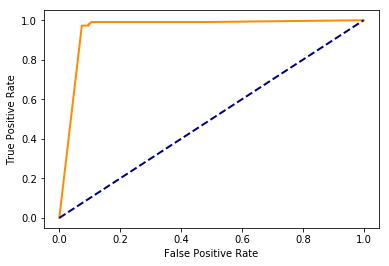

In [86]:
y_true = coding_scores_not_low_complexity_unspliced['in_cds_no_stop_codon']
y_score = coding_scores_not_low_complexity_unspliced['jaccard_in_peptide_db']
y_pred = y_score > 0.5

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)

fig, ax = plt.subplots()
lw = 2
ax.plot(fpr, tpr, lw=2, color='darkorange')
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

print("accuracy score:", metrics.accuracy_score(y_true, y_pred))

print(metrics.classification_report(y_true, y_pred))

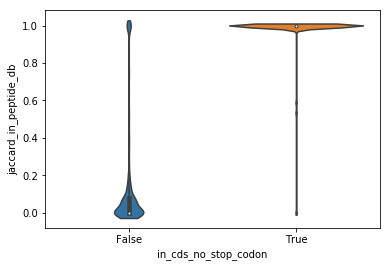

In [87]:


sns.violinplot(x='in_cds_no_stop_codon', y='jaccard_in_peptide_db', data=coding_scores_not_low_complexity_unspliced, 
               bw=0.1, cut=True)

## Where do they disagree?

### False negative - Low jaccard but the read is in the coding dataset
Truly a coding read but low "coding score"

In [90]:
coding_scores_not_low_complexity_unspliced.query("jaccard_in_peptide_db < 0.9 & in_cds_no_stop_codon == True").shape

(3, 6)

In [89]:
coding_scores_not_low_complexity_unspliced.query("jaccard_in_peptide_db < 0.9 & in_cds_no_stop_codon == True").head()

,read_id,jaccard_in_peptide_db,n_kmers,classification,short_read_id,in_cds_no_stop_codon
289,SRR306838.8536423 Ibis_Run100924_C3PO:6:41:4477:5833/1,0.588235,17,non-coding,SRR306838.8536423,True
740,SRR306838.4158712 Ibis_Run100924_C3PO:6:19:4365:17337/1,0.533333,15,non-coding,SRR306838.4158712,True
991,SRR306838.20339512 Ibis_Run100924_C3PO:6:102:15178:5329/1,0.000000,16,non-coding,SRR306838.20339512,True


In [91]:
df = coding_scores_not_low_complexity_unspliced.query("jaccard_in_peptide_db < 0.9 & in_cds_no_stop_codon == True")
for read_id in df.short_read_id:
    ! samtools view $folder/$unspliced_bam | grep $read_id

SRR306838.8536423	0	chr1	39448668	255	70M	*	0	0	AAAGACTTTGCTTCCCGAAGATACTCAGAAACTTGACAATTTCCTAGGAGAAGTCAGAGACAAATGGGAT	-0454575:38569357656746757387639475375567787758567758596:6957665665585	NH:i:1	HI:i:1	AS:i:66	nM:i:1	RG:Z:SRR306838_GSM752691_hsa_br_F_1
SRR306838.4158712	16	chrX	129814671	255	49M14S	*	0	0	GACGATGTTGAAGGCGAAGACATAGATTGTGAGGAGGGAGAAAGAAAGGGAAGTAGAAGTAGG	836857646958738766836846574664767626764766584546386474576222000	NH:i:1	HI:i:1	AS:i:46	nM:i:1	RG:Z:SRR306838_GSM752691_hsa_br_F_1
SRR306838.20339512	0	chr2	26192330	255	54M16S	*	0	0	CTTCGGACTCGCTAAAATACTATCCATGTCAGAATTCAAATCCTTCCTCTTCACTTATCATCTTCACAAT	31/3331654544412543575556554166666648555667768766468567466675:68555765	NH:i:1	HI:i:1	AS:i:51	nM:i:1	RG:Z:SRR306838_GSM752691_hsa_br_F_1


Read maps to "MACF1"

In [98]:
low_complexity_id = 'SRR306838.8932718'
! samtools view $folder/$unspliced_bam | grep $low_complexity_id

In [76]:


score_single_sequence("AAAGACTTTGCTTCCCGAAGATACTCAGAAACTTGACAATTTCCTAGGAGAAGTCAGAGACAAATGGGAT", peptide_graph, peptide_ksize)

	translation: 	KTLLPEDTQKLDNFLGEVRDKWD
	kmers: FLGEVRD DTQKLDN LPEDTQK KLDNFLG LLPEDTQ EVRDKWD GEVRDKW PEDTQKL TQKLDNF LDNFLGE EDTQKLD NFLGEVR LGEVRDK KTLLPED TLLPEDT DNFLGEV QKLDNFL
	K-mers in peptide database:
{('DNFLGEV', 7517166875925614125): 1,
 ('DTQKLDN', 5951274799996309732): 0,
 ('EDTQKLD', 14887061883264050655): 0,
 ('EVRDKWD', 829818351693786468): 1,
 ('FLGEVRD', 9516214906786795876): 1,
 ('GEVRDKW', 8385754174638241851): 1,
 ('KLDNFLG', 3011079111732742999): 1,
 ('KTLLPED', 14836733754548320237): 1,
 ('LDNFLGE', 14534966961722312621): 1,
 ('LGEVRDK', 79391250229811418): 1,
 ('LLPEDTQ', 14973099275059575838): 0,
 ('LPEDTQK', 7311319343166724544): 0,
 ('NFLGEVR', 966627286140107258): 1,
 ('PEDTQKL', 908198253004630471): 0,
 ('QKLDNFL', 4722373045142000694): 1,
 ('TLLPEDT', 7583591577639096127): 0,
 ('TQKLDNF', 1242088564466415818): 0}


(0.5882352941176471, 17)

In [64]:
unspliced_bam = 'SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.bam'

# This reads aligns to the CBLN2 
noncoding_read_id = 'SRR306838.8536423'
! samtools view $folder/$unspliced_bam | grep $noncoding_read_id

SRR306838.8536423	0	chr1	39448668	255	70M	*	0	0	AAAGACTTTGCTTCCCGAAGATACTCAGAAACTTGACAATTTCCTAGGAGAAGTCAGAGACAAATGGGAT	-0454575:38569357656746757387639475375567787758567758596:6957665665585	NH:i:1	HI:i:1	AS:i:66	nM:i:1	RG:Z:SRR306838_GSM752691_hsa_br_F_1


In [44]:
unspliced_bam = 'SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.bam'

# This reads aligns to the CBLN2 
noncoding_read_id = 'SRR306838.733972	'
! samtools view $folder/$unspliced_bam | grep $noncoding_read_id

SRR306838.7339725	0	chr3	194639082	255	57M	*	0	0	TTGGGGCAAAACACTGGTCCTCTCTGCACTTGTGTGTTCCTTTCTGTAAAAGGAGGA	-4566323463646545356576866534585655666655868:953234765867	NH:i:1	HI:i:1	AS:i:56	nM:i:0	RG:Z:SRR306838_GSM752691_hsa_br_F_1
SRR306838.733972	16	chr18	72538162	255	49M	*	0	0	AGGGAGCTCTGTGTTTATAGAGGAAACACCAAGAAGCCCGAGAATGTGG	6666776687536257653736764476765533375546588363312	NH:i:1	HI:i:1	AS:i:46	nM:i:1	RG:Z:SRR306838_GSM752691_hsa_br_F_1


In [45]:
unspliced_bam = 'SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.bam'

# This reads aligns to the CBLN2 
noncoding_read_id = 'SRR306838.17561853	'
! samtools view $folder/$unspliced_bam | grep $noncoding_read_id

SRR306838.17561853	16	chrM	3811	255	67M	*	0	0	CAAGAACACCTCTGATTACTCCTGCCATCATGACCCTTGGCCATAATATGATTTATCTCCACACTAG	78677564566847334362785755:66:5525674587556457767724344164757626035	NH:i:1	HI:i:1	AS:i:65	nM:i:0	RG:Z:SRR306838_GSM752691_hsa_br_F_1


In [49]:
df = coding_scores_unspliced.query("jaccard_in_peptide_db < 0.5 & in_cds_no_stop_codon == True")
for read_id in df.short_read_id:
    ! samtools view $folder/$unspliced_bam | grep $read_id

SRR306838.17561853	16	chrM	3811	255	67M	*	0	0	CAAGAACACCTCTGATTACTCCTGCCATCATGACCCTTGGCCATAATATGATTTATCTCCACACTAG	78677564566847334362785755:66:5525674587556457767724344164757626035	NH:i:1	HI:i:1	AS:i:65	nM:i:0	RG:Z:SRR306838_GSM752691_hsa_br_F_1
SRR306838.3607263	16	chrM	8401	255	12S60M	*	0	0	GTCATGCAAAAGAATTACCCCCATACTCCTTACACTATTCCTTATCACCCAACTAAAAACATTAAACACAAA	557:977:86<;8744366867844:78935686846668:434655896;58479533962386971613.	NH:i:1	HI:i:1	AS:i:55	nM:i:2	RG:Z:SRR306838_GSM752691_hsa_br_F_1
SRR306838.23727244	16	chrM	14157	255	66M	*	0	0	CCCGAGCAATCTCAATTACAATATATACACCAACAAACAATGTTCAACCAGTAACTACTACTAATC	6678867778855785236875525246355726854665351366456341337226254200.1	NH:i:1	HI:i:1	AS:i:64	nM:i:0	RG:Z:SRR306838_GSM752691_hsa_br_F_1
SRR306838.3497462	16	chrM	8428	255	58M	*	0	0	CCTCATCACCCAACTAAAAACATTAAACACAAACTACCACCTACCTCCCTCACCAAAG	7:78:573468:571665736743343457634611672683/472883267672035	NH:i:1	HI:i:1	AS:i:55	nM:i:1	RG:Z:SRR306838_GSM752691_hsa_br_F_1
SRR306838.12840151	1

A lot of these are chromosome M (mitochondria) so let's ignore all reads mapping to the mitochondria

In [46]:
unspliced_bam = 'SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.bam'

# This reads aligns to the CBLN2 
noncoding_read_id = 'SRR306838.3607263'
! samtools view $folder/$unspliced_bam | grep $noncoding_read_id

SRR306838.3607263	16	chrM	8401	255	12S60M	*	0	0	GTCATGCAAAAGAATTACCCCCATACTCCTTACACTATTCCTTATCACCCAACTAAAAACATTAAACACAAA	557:977:86<;8744366867844:78935686846668:434655896;58479533962386971613.	NH:i:1	HI:i:1	AS:i:55	nM:i:2	RG:Z:SRR306838_GSM752691_hsa_br_F_1


In [47]:
unspliced_bam = 'SRR306838_GSM752691_hsa_br_F_1Aligned.sortedByCoord.out.bam.unspliced.bam'

# This reads aligns to the CBLN2 
noncoding_read_id = 'SRR306838.23727244'
! samtools view $folder/$unspliced_bam | grep $noncoding_read_id

SRR306838.23727244	16	chrM	14157	255	66M	*	0	0	CCCGAGCAATCTCAATTACAATATATACACCAACAAACAATGTTCAACCAGTAACTACTACTAATC	6678867778855785236875525246355726854665351366456341337226254200.1	NH:i:1	HI:i:1	AS:i:64	nM:i:0	RG:Z:SRR306838_GSM752691_hsa_br_F_1


In [24]:
from khtools.partition_reads import score_single_sequence
s = "CAAGAACACCTCTGATTACTCCTGCCATCATGACCCTTGGCCATAATATGATTTATCTCCACACTAG"
seq = Seq(s)

score_single_sequence(s, peptide_graph, peptide_ksize, 'protein', verbose=True)

	translation: 	RTPLITPAIMTLGHNMIYLHT
	kmers: NMIYLHT PLITPAI TPLITPA LITPAIM AIMTLGH HNMIYLH GHNMIYL ITPAIMT RTPLITP IMTLGHN MTLGHNM TLGHNMI TPAIMTL PAIMTLG LGHNMIY
	K-mers in peptide database:
{('AIMTLGH', 4934959604245948732): 0,
 ('GHNMIYL', 8679214931415330990): 0,
 ('HNMIYLH', 9860068405428524224): 0,
 ('IMTLGHN', 5007379133261696389): 0,
 ('ITPAIMT', 1845456223218030233): 0,
 ('LGHNMIY', 14440126941365645435): 0,
 ('LITPAIM', 12273716599056031256): 0,
 ('MTLGHNM', 8490348177331113914): 0,
 ('NMIYLHT', 5523607257588686990): 0,
 ('PAIMTLG', 2938204897806652236): 0,
 ('PLITPAI', 1294566589529317893): 0,
 ('RTPLITP', 14525035971622691714): 0,
 ('TLGHNMI', 15987995585519721535): 0,
 ('TPAIMTL', 2070009544365237801): 0,
 ('TPLITPA', 14027991606434210618): 0}
	translation: 	SVEINHIMAKGHDGRSNQRCS
	kmers: RSNQRCS EINHIMA GHDGRSN DGRSNQR GRSNQRC AKGHDGR INHIMAK HDGRSNQ SVEINHI VEINHIM KGHDGRS NHIMAKG IMAKGHD HIMAKGH MAKGHDG
	K-mers in peptide database:
{('AKGHDGR', 11854149275921946754): 0

(0, 15)

In [ ]:
hash_murmur("QSSSPEF")

In [ ]:
peptide_graph.get(9478686570769398934)

In [92]:
for record in tqdm(screed.open('Homo_sapiens.GRCh38.pep.all.fa.gz')):
    if 'QSSSPEFRVQSFSERTNARKKNNH' in record['sequence']:
        print("---- QSSSPEFRVQSFSERTNARKKNNH ----")
        print(record)
    if "TOPORS" in record['name']:
        print("---- TOPORS ----")
        print(record)

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/screed/openscreed.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='Homo_sapiens.GRCh38.pep.all.fa.gz'>
  self.iter_fn = self.open_reader(filename, *args, **kwargs)
46151it [00:01, 36395.48it/s]

---- QSSSPEFRVQSFSERTNARKKNNH ----
{'name': 'ENSP00000353735.2 pep chromosome:GRCh38:9:32540544:32552586:-1 gene:ENSG00000197579.8 transcript:ENST00000360538.7 gene_biotype:protein_coding transcript_biotype:protein_coding gene_symbol:TOPORS description:TOP1 binding arginine/serine rich protein [Source:HGNC Symbol;Acc:HGNC:21653]', 'sequence': 'MGSQPPLGSPLSREEGEAPPPAPASEGRRRSRRVRLRGSCRHRPSFLGCRELAASAPARPAPASSEIMASAAKEFKMDNFSPKAGTSKLQQTVPADASPDSKCPICLDRFDNVSYLDRCLHKFCFRCVQEWSKNKAECPLCKQPFDSIFHSVRAEDDFKEYVLRPSYNGSFVTPDRRFRYRTTLTRERNASVYSPSGPVNRRTTTPPDSGVLFEGLGISTRPRDVEIPQFMRQIAVRRPTTADERSLRKIQEQDIINFRRTLYRAGARVRNIEDGGRYRDISAEFFRRNPACLHRLVPWLKRELTVLFGAHGSLVNIVQHIIMSNVTRYDLESQAFVSDLRPFLLNRTEHFIHEFISFARSPFNMAAFDQHANYDCPAPSYEEGSHSDSSVITISPDEAETQELDINVATVSQAPWDDETPGPSYSSSEQVHVTMSSLLNTSDSSDEELVTGGATSQIQGVQTNDDLNNDSDDSSDNCVIVGFVKPLAERTPELVELSSDSEDLGSYEKMETVKTQEQEQSYSSGDSDVSRCSSPHSVLGKDEQINKGHCDSSTRIKSKKEEKRSTSLSSPRNLNSSVRGDRVYSPYNHRHRKRGRSRSSDSRSQSRSGHDQKNHRKHHGKKRMKSKRSRSRESSRPRGRRDKKRSRTRDSSWS

110048it [00:03, 36127.01it/s]


In [51]:
is_low_complexity(s, 21)

(False, 51)

In [47]:
six_frame_translation_no_stops(seq)

[Seq('LECEITYFMCLLTKNTNDKGKSH', ExtendedIUPACProtein()),
 Seq('WLFPLSLVFLVRRHMKYVISHSR', ExtendedIUPACProtein())]

## False positive - high jaccard but in noncoding set

In [69]:
false_positives = coding_scores_not_low_complexity_unspliced.query("jaccard_in_peptide_db > 0.9 & in_cds_no_stop_codon == False")
print(false_positives.shape)
false_positives.head()

(67, 6)


,read_id,jaccard_in_peptide_db,n_kmers,classification,short_read_id,in_cds_no_stop_codon
20,SRR306838.7944356 Ibis_Run100924_C3PO:6:38:5591:5659/1,1.0,7,coding,SRR306838.7944356,False
64,SRR306838.6939297 Ibis_Run100924_C3PO:6:33:5394:5316/1,1.0,15,coding,SRR306838.6939297,False
66,SRR306838.23317726 Ibis_Run100924_C3PO:6:115:10861:16547/1,1.0,17,coding,SRR306838.23317726,False
82,SRR306838.18085420 Ibis_Run100924_C3PO:6:91:3302:10193/1,1.0,16,coding,SRR306838.18085420,False
106,SRR306838.16938253 Ibis_Run100924_C3PO:6:85:7026:15703/1,1.0,17,coding,SRR306838.16938253,False


In [70]:

noncoding_read_id = 'SRR306838.7944356	'
! samtools view $folder/$unspliced_bam | grep $noncoding_read_id

SRR306838.7944356	16	chr19	6501568	255	42M	*	0	0	CCATGGTATGTGCCTGTGGGGTCGATGCCATGTTCGTCACTG	569626336635575648568542566376495452670712	NH:i:1	HI:i:1	AS:i:41	nM:i:0	RG:Z:SRR306838_GSM752691_hsa_br_F_1


In [73]:

noncoding_read_id = 'SRR306838.6939297	'
! samtools view $folder/$unspliced_bam | grep $noncoding_read_id

SRR306838.6939297	16	chr11	63758272	255	65M	*	0	0	ATGAAGGAAAATACTCAGTGTCAGCTTGAGCCTGCATTCCAAGCTTTTTTTTTAATTTGGTGTTT	57:6669965;82667:64748:4:588668966785767898958667558635755376530.	NH:i:1	HI:i:1	AS:i:63	nM:i:0	RG:Z:SRR306838_GSM752691_hsa_br_F_1
